# XGBoost

In [ ]:
!pip install xgboost
!pip install tensorflow-addons
!pip install optuna

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import tensorflow as tf
import tensorflow_addons as tfa
import optuna
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sklearn
from sklearn import metrics as sklearn_metrics
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, accuracy_score,
    roc_auc_score, average_precision_score, log_loss
)
import matplotlib.pyplot as plt

import constants

In [5]:
# Load training data then pass through CNN as a "feature extraction"
random_seed = 21

train_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_training_augmented_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_validation_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_testing_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

Found 16005 files belonging to 8 classes.
Found 2028 files belonging to 8 classes.
Found 5066 files belonging to 8 classes.


In [8]:
model = tf.keras.models.load_model("saved_models/cnn_efficientnet/best_en_16k_tuned_2x_model.h5")
only_cnn = tf.keras.Sequential(model.layers[:3])

In [9]:
only_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_layers (Sequential)    (None, 25)                38525     
Total params: 10,822,060
Trainable params: 3,411,627
Non-trainable params: 7,410,433
_________________________________________________________________


In [12]:
# Get "extracted" features using CNN

# Training data
train_cnn_output = only_cnn.predict(train_ds)
train_y = np.array(list(train_ds.unbatch().map(lambda x, y: y).as_numpy_iterator()))
print(f"{train_cnn_output.shape=}")
print(f"{train_y.shape=}")

# Validation data
validation_cnn_output = only_cnn.predict(validation_ds)
validation_y = np.array(list(validation_ds.unbatch().map(lambda x, y: y).as_numpy_iterator()))
print(f"{validation_cnn_output.shape=}")
print(f"{validation_y.shape=}")

# Testing data
test_cnn_output = only_cnn.predict(test_ds)
test_y = np.array(list(test_ds.unbatch().map(lambda x, y: y).as_numpy_iterator()))
print(f"{test_cnn_output.shape=}")
print(f"{test_y.shape=}")

train_cnn_output.shape=(16005, 25)
train_y.shape=(16005, 8)
validation_cnn_output.shape=(2028, 25)
validation_y.shape=(2028, 8)
test_cnn_output.shape=(5066, 25)
test_y.shape=(5066, 8)


In [11]:
# Subset for seeing if code works
import sklearn

subset_idx = sklearn.utils.random.sample_without_replacement(train_cnn_output.shape[0], 2000)
subset_cnn_output = train_cnn_output[subset_idx]
subset_y = train_y[subset_idx]
print(f"{subset_cnn_output.shape=}")
print(f"{subset_y.shape=}")

subset_cnn_output.shape=(2000, 20)
subset_y.shape=(2000, 8)


In [27]:
# Testing out on small subset
my_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=8,
)
# Test on small subset
my_model.fit(subset_cnn_output, np.argmax(subset_y, axis=1))
# my_model.fit(train_cnn_output, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=8, num_parallel_tree=1,
              objective='multi:softmax', ...)

In [13]:
class CustomCallback(xgb.callback.TrainingCallback):
    def after_iteration(self, model, epoch, evals_log):
        print(f"Epoch {epoch}: {evals_log}")
        print(type(model))
        super().after_iteration(model, epoch, evals_log)

In [14]:
# Real training -- method 1
my_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=8,
    max_depth=6, # default
    callbacks=[
        # CustomCallback(),
        # xgb.callback.EarlyStopping(rounds=5),
    ],
    n_estimators=20,
    subsample=0.5,
    colsample_bytree=0.5,
    # num_parallel_tree=20,  # for random forests, otherwise default = 1
)

my_model.fit(
    train_cnn_output, np.argmax(train_y, axis=1), 
    eval_set=[
        (train_cnn_output, np.argmax(train_y, axis=1)),
        (validation_cnn_output, np.argmax(validation_y, axis=1)),
    ],
    # num_boost_round=1,  # set to 1 for unboosted random forests
)

[0]	validation_0-mlogloss:2.06860	validation_1-mlogloss:2.08239
[1]	validation_0-mlogloss:2.06012	validation_1-mlogloss:2.08680
[2]	validation_0-mlogloss:2.04815	validation_1-mlogloss:2.08170
[3]	validation_0-mlogloss:2.04002	validation_1-mlogloss:2.08228
[4]	validation_0-mlogloss:2.02993	validation_1-mlogloss:2.08539
[5]	validation_0-mlogloss:2.02164	validation_1-mlogloss:2.08666
[6]	validation_0-mlogloss:2.01042	validation_1-mlogloss:2.09399
[7]	validation_0-mlogloss:2.00048	validation_1-mlogloss:2.09215
[8]	validation_0-mlogloss:1.99359	validation_1-mlogloss:2.09492
[9]	validation_0-mlogloss:1.98577	validation_1-mlogloss:2.09800
[10]	validation_0-mlogloss:1.97626	validation_1-mlogloss:2.09551
[11]	validation_0-mlogloss:1.96837	validation_1-mlogloss:2.09480
[12]	validation_0-mlogloss:1.96089	validation_1-mlogloss:2.09799
[13]	validation_0-mlogloss:1.95301	validation_1-mlogloss:2.09438
[14]	validation_0-mlogloss:1.94519	validation_1-mlogloss:2.09035
[15]	validation_0-mlogloss:1.93499	

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=[],
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=0,
              num_class=8, num_parallel_tree=1, objective='multi:softmax', ...)

In [15]:
# Real training - method 2 as borrowed from this article: https://www.kaggle.com/code/mrleritaite/cnn-xgboost/notebook
dataset_train = xgb.DMatrix(train_cnn_output, label=np.argmax(train_y, axis=1))
dataset_val = xgb.DMatrix(validation_cnn_output, label=np.argmax(validation_y, axis=1))
watchlist = [(dataset_train, 'train'), (dataset_val, 'validation')]
params = {'max_depth':7, 'eta':0.1, 'silent':1, 'num_class':8,'objective':'multi:softmax' } 
my_model = xgb.train(params, dataset_train, num_boost_round=150, evals=watchlist)

[07:31:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mlogloss:2.07161	validation-mlogloss:2.07929
[1]	train-mlogloss:2.06452	validation-mlogloss:2.07906
[2]	train-mlogloss:2.05812	validation-mlogloss:2.07951
[3]	train-mlogloss:2.05229	validation-mlogloss:2.07947
[4]	train-mlogloss:2.04631	validation-mlogloss:2.07931
[5]	train-mlogloss:2.03982	validation-mlogloss:2.08083
[6]	train-mlogloss:2.03461	validation-mlogloss:2.08060
[7]	train-mlogloss:2.03047	validation-mlogloss:2.08196
[8]	train-mlogloss:2.02546	validation-mlogloss:2.08258
[9]	train-mlogloss:2.02147	validation-mlogloss:2.08346
[10]	train-mlogloss:2.01719	validation-mlogloss:2.08340
[11]	train-mlogloss:2.01307	validation-mlogloss:2.08307
[12]	train-mlogloss:2.00746	validation-mlogloss:2.08345
[13]	train-mlogloss:2.00337	validation-mlogloss:2.08326
[14]	train-mlogloss:1.99862	validation-mlogloss:2.08311
[15]	train-mlogloss:1.99529	validation-mlogloss:2.08336
[16]	train-mlogloss:1.99155	va

Analysis: while the loss function is decreasing (great!), the validation loss function barely decreased, and in fact increased back up towards the end (not great). This shows some level of overfitting.

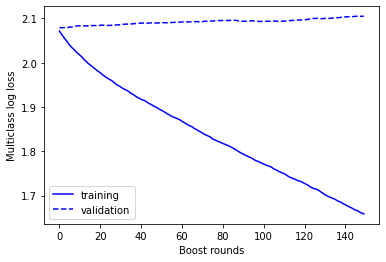

In [26]:
train_loss = [2.07161, 2.06452, 2.05812, 2.05229, 2.04631, 2.03982, 2.03461, 2.03047, 2.02546, 2.02147, 2.01719, 2.01307, 2.00746, 2.00337, 1.99862, 1.99529, 1.99155, 1.98770, 1.98397, 1.98040, 1.97760, 1.97325, 1.96979, 1.96655, 1.96370, 1.96129, 1.95845, 1.95444, 1.95041, 1.94810, 1.94539, 1.94197, 1.93969, 1.93768, 1.93467, 1.93100, 1.92866, 1.92541, 1.92263, 1.91969, 1.91741, 1.91556, 1.91392, 1.91052, 1.90773, 1.90568, 1.90224, 1.90048, 1.89799, 1.89472, 1.89277, 1.88996, 1.88688, 1.88431, 1.88201, 1.87873, 1.87686, 1.87538, 1.87312, 1.87109, 1.86751, 1.86522, 1.86216, 1.85938, 1.85728, 1.85532, 1.85155, 1.84969, 1.84628, 1.84411, 1.84106, 1.83839, 1.83648, 1.83432, 1.83190, 1.82807, 1.82598, 1.82378, 1.82161, 1.81982, 1.81784, 1.81609, 1.81408, 1.81221, 1.80990, 1.80733, 1.80465, 1.80161, 1.79871, 1.79617, 1.79356, 1.79112, 1.78939, 1.78674, 1.78506, 1.78217, 1.77918, 1.77772, 1.77584, 1.77339, 1.77138, 1.76922, 1.76742, 1.76590, 1.76361, 1.76002, 1.75847, 1.75572, 1.75339, 1.75115, 1.74976, 1.74689, 1.74369, 1.74127, 1.73921, 1.73739, 1.73549, 1.73327, 1.73226, 1.72999, 1.72790, 1.72528, 1.72265, 1.71912, 1.71701, 1.71562, 1.71410, 1.71186, 1.70833, 1.70539, 1.70207, 1.69960, 1.69752, 1.69517, 1.69330, 1.69172, 1.68845, 1.68670, 1.68456, 1.68160, 1.67937, 1.67664, 1.67456, 1.67233, 1.66951, 1.66717, 1.66597, 1.66273, 1.66051, 1.65870]
val_loss = [2.07929, 2.07906, 2.07951, 2.07947, 2.07931, 2.08083, 2.08060, 2.08196, 2.08258, 2.08346, 2.08340, 2.08307, 2.08345, 2.08326, 2.08311, 2.08336, 2.08394, 2.08391, 2.08366, 2.08395, 2.08436, 2.08496, 2.08451, 2.08424, 2.08419, 2.08439, 2.08498, 2.08533, 2.08520, 2.08571, 2.08622, 2.08682, 2.08713, 2.08731, 2.08702, 2.08757, 2.08790, 2.08847, 2.08863, 2.08914, 2.08956, 2.08952, 2.08929, 2.08927, 2.08998, 2.09001, 2.08971, 2.08970, 2.08971, 2.08990, 2.09043, 2.09045, 2.09044, 2.09018, 2.09042, 2.09089, 2.09120, 2.09143, 2.09138, 2.09174, 2.09217, 2.09245, 2.09223, 2.09218, 2.09246, 2.09268, 2.09267, 2.09313, 2.09252, 2.09269, 2.09289, 2.09361, 2.09372, 2.09350, 2.09389, 2.09408, 2.09470, 2.09509, 2.09513, 2.09506, 2.09535, 2.09557, 2.09529, 2.09555, 2.09596, 2.09598, 2.09586, 2.09549, 2.09330, 2.09352, 2.09382, 2.09360, 2.09380, 2.09408, 2.09489, 2.09453, 2.09316, 2.09361, 2.09323, 2.09350, 2.09335, 2.09365, 2.09351, 2.09369, 2.09380, 2.09413, 2.09425, 2.09315, 2.09359, 2.09377, 2.09384, 2.09451, 2.09487, 2.09533, 2.09568, 2.09610, 2.09619, 2.09636, 2.09646, 2.09664, 2.09705, 2.09754, 2.09837, 2.09934, 2.09981, 2.10009, 2.10028, 2.10030, 2.09932, 2.09996, 2.10008, 2.10017, 2.10051, 2.10047, 2.10086, 2.10142, 2.10178, 2.10177, 2.10310, 2.10375, 2.10346, 2.10387, 2.10416, 2.10407, 2.10427, 2.10501, 2.10469, 2.10469, 2.10487, 2.10500]

plt.plot(train_loss, "b-", label="training")
plt.plot(val_loss, "b--", label="validation")
plt.xlabel("Boost rounds")
plt.ylabel("Multiclass log loss")
plt.legend();

In [16]:
# Get a taste of what the trees look like
my_model.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,f23,1.774662,0-1,0-2,0-1,3.063034,3501.093750,NaN
1,0,1,0-1,f2,3.778466,0-3,0-4,0-3,3.202192,2850.312500,NaN
2,0,2,0-2,f2,-0.259797,0-5,0-6,0-5,4.990823,650.781250,NaN
3,0,3,0-3,f3,4.657824,0-7,0-8,0-7,3.069252,2647.312500,NaN
4,0,4,0-4,f2,3.913094,0-9,0-10,0-9,3.266931,203.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
87399,1199,104,1199-104,Leaf,NaN,NaN,NaN,NaN,-0.009865,1.924719,NaN
87400,1199,105,1199-105,Leaf,NaN,NaN,NaN,NaN,0.029424,1.856762,NaN
87401,1199,106,1199-106,Leaf,NaN,NaN,NaN,NaN,-0.034133,22.860502,NaN
87402,1199,107,1199-107,Leaf,NaN,NaN,NaN,NaN,0.046002,7.923193,NaN


## Another version of XGBoost -- boost with random forests?

Might be slightly computationally heavy. Gotta be slightly careful about number of trees (limit to max of 6 for now).

In [23]:
# Real training - method 2 as borrowed from this article: https://www.kaggle.com/code/mrleritaite/cnn-xgboost/notebook
dataset_train = xgb.DMatrix(train_cnn_output, label=np.argmax(train_y, axis=1))
dataset_val = xgb.DMatrix(validation_cnn_output, label=np.argmax(validation_y, axis=1))
watchlist = [(dataset_train, 'train'), (dataset_val, 'validation')]

best_bst = None
best_loss = 1e5

def objective(trial):
    global best_bst
    global best_loss
    
    booster_choice = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    
    params = {
        'eta': 0.1,
        'booster': booster_choice,
        'num_class': 8,
        'objective': 'multi:softmax',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
    }
    
    if booster_choice == "gbtree":
        params.update({
            "num_parallel_tree": trial.suggest_int("num_parallel_tree", 1, 6),
            'max_depth': trial.suggest_int("max_depth", 3, 12),
        })
        
    bst = xgb.train(params, dataset_train, num_boost_round=50, evals=watchlist, verbose_eval=False)
    
    val_loss = float(bst.eval(dataset_val).split("mlogloss:")[-1])
    if val_loss < best_loss:
        best_loss = val_loss
        best_bst = bst

    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2022-12-06 07:43:05,362] A new study created in memory with name: no-name-11e66b7b-4d4d-4224-8774-d84cd822994b
[I 2022-12-06 07:43:08,159] Trial 0 finished with value: 2.082927430640076 and parameters: {'booster': 'gbtree', 'lambda': 2.6145413020270743e-07, 'alpha': 0.1857720257430455, 'num_parallel_tree': 1, 'max_depth': 3}. Best is trial 0 with value: 2.082927430640076.
[I 2022-12-06 07:43:25,802] Trial 1 finished with value: 2.0875701816124326 and parameters: {'booster': 'dart', 'lambda': 1.0052272935760201e-05, 'alpha': 0.06221407535446576}. Best is trial 0 with value: 2.082927430640076.
[I 2022-12-06 07:43:43,351] Trial 2 finished with value: 2.089315070467588 and parameters: {'booster': 'dart', 'lambda': 1.656045205793017e-06, 'alpha': 4.011043606595319e-06}. Best is trial 0 with value: 2.082927430640076.
[I 2022-12-06 07:43:44,334] Trial 3 finished with value: 2.0681248657567024 and parameters: {'booster': 'gblinear', 'lambda': 4.992174564285349e-06, 'alpha': 1.06750219624597

In [36]:
# Real training - method 2 as borrowed from this article: https://www.kaggle.com/code/mrleritaite/cnn-xgboost/notebook
dataset_train = xgb.DMatrix(train_cnn_output, label=np.argmax(train_y, axis=1))
dataset_val = xgb.DMatrix(validation_cnn_output, label=np.argmax(validation_y, axis=1))
watchlist = [(dataset_train, 'train'), (dataset_val, 'validation')]
params = {'booster': 'gblinear', 'eta':0.1, 'num_class':8,'objective':'multi:softmax', 'lambda': 4.379460431685878e-05, 'alpha': 8.166861954947548e-05} 
my_model_linear = xgb.train(
    params, dataset_train, num_boost_round=300, evals=watchlist,
)

[0]	train-mlogloss:2.07917	validation-mlogloss:2.07794
[1]	train-mlogloss:2.07894	validation-mlogloss:2.07661
[2]	train-mlogloss:2.07874	validation-mlogloss:2.07545
[3]	train-mlogloss:2.07858	validation-mlogloss:2.07441
[4]	train-mlogloss:2.07843	validation-mlogloss:2.07352
[5]	train-mlogloss:2.07831	validation-mlogloss:2.07275
[6]	train-mlogloss:2.07820	validation-mlogloss:2.07207
[7]	train-mlogloss:2.07811	validation-mlogloss:2.07146
[8]	train-mlogloss:2.07803	validation-mlogloss:2.07094
[9]	train-mlogloss:2.07796	validation-mlogloss:2.07049
[10]	train-mlogloss:2.07790	validation-mlogloss:2.07009
[11]	train-mlogloss:2.07784	validation-mlogloss:2.06974
[12]	train-mlogloss:2.07779	validation-mlogloss:2.06943
[13]	train-mlogloss:2.07775	validation-mlogloss:2.06917
[14]	train-mlogloss:2.07771	validation-mlogloss:2.06894
[15]	train-mlogloss:2.07768	validation-mlogloss:2.06873
[16]	train-mlogloss:2.07765	validation-mlogloss:2.06854
[17]	train-mlogloss:2.07762	validation-mlogloss:2.06838
[1

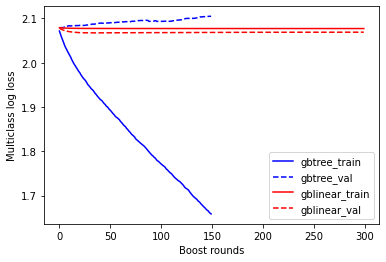

In [38]:
gbtree_train_loss = [2.07161, 2.06452, 2.05812, 2.05229, 2.04631, 2.03982, 2.03461, 2.03047, 2.02546, 2.02147, 2.01719, 2.01307, 2.00746, 2.00337, 1.99862, 1.99529, 1.99155, 1.98770, 1.98397, 1.98040, 1.97760, 1.97325, 1.96979, 1.96655, 1.96370, 1.96129, 1.95845, 1.95444, 1.95041, 1.94810, 1.94539, 1.94197, 1.93969, 1.93768, 1.93467, 1.93100, 1.92866, 1.92541, 1.92263, 1.91969, 1.91741, 1.91556, 1.91392, 1.91052, 1.90773, 1.90568, 1.90224, 1.90048, 1.89799, 1.89472, 1.89277, 1.88996, 1.88688, 1.88431, 1.88201, 1.87873, 1.87686, 1.87538, 1.87312, 1.87109, 1.86751, 1.86522, 1.86216, 1.85938, 1.85728, 1.85532, 1.85155, 1.84969, 1.84628, 1.84411, 1.84106, 1.83839, 1.83648, 1.83432, 1.83190, 1.82807, 1.82598, 1.82378, 1.82161, 1.81982, 1.81784, 1.81609, 1.81408, 1.81221, 1.80990, 1.80733, 1.80465, 1.80161, 1.79871, 1.79617, 1.79356, 1.79112, 1.78939, 1.78674, 1.78506, 1.78217, 1.77918, 1.77772, 1.77584, 1.77339, 1.77138, 1.76922, 1.76742, 1.76590, 1.76361, 1.76002, 1.75847, 1.75572, 1.75339, 1.75115, 1.74976, 1.74689, 1.74369, 1.74127, 1.73921, 1.73739, 1.73549, 1.73327, 1.73226, 1.72999, 1.72790, 1.72528, 1.72265, 1.71912, 1.71701, 1.71562, 1.71410, 1.71186, 1.70833, 1.70539, 1.70207, 1.69960, 1.69752, 1.69517, 1.69330, 1.69172, 1.68845, 1.68670, 1.68456, 1.68160, 1.67937, 1.67664, 1.67456, 1.67233, 1.66951, 1.66717, 1.66597, 1.66273, 1.66051, 1.65870]
gbtree_val_loss = [2.07929, 2.07906, 2.07951, 2.07947, 2.07931, 2.08083, 2.08060, 2.08196, 2.08258, 2.08346, 2.08340, 2.08307, 2.08345, 2.08326, 2.08311, 2.08336, 2.08394, 2.08391, 2.08366, 2.08395, 2.08436, 2.08496, 2.08451, 2.08424, 2.08419, 2.08439, 2.08498, 2.08533, 2.08520, 2.08571, 2.08622, 2.08682, 2.08713, 2.08731, 2.08702, 2.08757, 2.08790, 2.08847, 2.08863, 2.08914, 2.08956, 2.08952, 2.08929, 2.08927, 2.08998, 2.09001, 2.08971, 2.08970, 2.08971, 2.08990, 2.09043, 2.09045, 2.09044, 2.09018, 2.09042, 2.09089, 2.09120, 2.09143, 2.09138, 2.09174, 2.09217, 2.09245, 2.09223, 2.09218, 2.09246, 2.09268, 2.09267, 2.09313, 2.09252, 2.09269, 2.09289, 2.09361, 2.09372, 2.09350, 2.09389, 2.09408, 2.09470, 2.09509, 2.09513, 2.09506, 2.09535, 2.09557, 2.09529, 2.09555, 2.09596, 2.09598, 2.09586, 2.09549, 2.09330, 2.09352, 2.09382, 2.09360, 2.09380, 2.09408, 2.09489, 2.09453, 2.09316, 2.09361, 2.09323, 2.09350, 2.09335, 2.09365, 2.09351, 2.09369, 2.09380, 2.09413, 2.09425, 2.09315, 2.09359, 2.09377, 2.09384, 2.09451, 2.09487, 2.09533, 2.09568, 2.09610, 2.09619, 2.09636, 2.09646, 2.09664, 2.09705, 2.09754, 2.09837, 2.09934, 2.09981, 2.10009, 2.10028, 2.10030, 2.09932, 2.09996, 2.10008, 2.10017, 2.10051, 2.10047, 2.10086, 2.10142, 2.10178, 2.10177, 2.10310, 2.10375, 2.10346, 2.10387, 2.10416, 2.10407, 2.10427, 2.10501, 2.10469, 2.10469, 2.10487, 2.10500]
gblinear_train_loss = [2.07917, 2.07894, 2.07874, 2.07858, 2.07843, 2.07831, 2.07820, 2.07811, 2.07803, 2.07796, 2.07790, 2.07784, 2.07779, 2.07775, 2.07771, 2.07768, 2.07765, 2.07762, 2.07760, 2.07758, 2.07756, 2.07754, 2.07752, 2.07751, 2.07749, 2.07748, 2.07747, 2.07746, 2.07745, 2.07744, 2.07743, 2.07742, 2.07742, 2.07741, 2.07740, 2.07740, 2.07739, 2.07739, 2.07738, 2.07738, 2.07737, 2.07737, 2.07737, 2.07736, 2.07736, 2.07736, 2.07735, 2.07735, 2.07735, 2.07734, 2.07734, 2.07734, 2.07734, 2.07733, 2.07733, 2.07733, 2.07733, 2.07733, 2.07732, 2.07732, 2.07732, 2.07732, 2.07732, 2.07732, 2.07731, 2.07731, 2.07731, 2.07731, 2.07731, 2.07731, 2.07731, 2.07730, 2.07730, 2.07730, 2.07730, 2.07730, 2.07730, 2.07730, 2.07729, 2.07729, 2.07729, 2.07729, 2.07729, 2.07729, 2.07729, 2.07729, 2.07729, 2.07729, 2.07728, 2.07728, 2.07728, 2.07728, 2.07728, 2.07728, 2.07728, 2.07728, 2.07728, 2.07728, 2.07727, 2.07727, 2.07727, 2.07727, 2.07727, 2.07727, 2.07727, 2.07727, 2.07727, 2.07727, 2.07727, 2.07727, 2.07727, 2.07727, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07726, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07725, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07724, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07723, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722, 2.07722]
gblinear_val_loss = [2.07794, 2.07661, 2.07545, 2.07441, 2.07352, 2.07275, 2.07207, 2.07146, 2.07094, 2.07049, 2.07009, 2.06974, 2.06943, 2.06917, 2.06894, 2.06873, 2.06854, 2.06838, 2.06824, 2.06812, 2.06801, 2.06791, 2.06783, 2.06776, 2.06770, 2.06765, 2.06761, 2.06758, 2.06755, 2.06752, 2.06750, 2.06748, 2.06747, 2.06747, 2.06747, 2.06747, 2.06746, 2.06746, 2.06746, 2.06747, 2.06749, 2.06749, 2.06750, 2.06751, 2.06752, 2.06753, 2.06755, 2.06757, 2.06758, 2.06759, 2.06760, 2.06762, 2.06764, 2.06766, 2.06767, 2.06769, 2.06771, 2.06772, 2.06774, 2.06776, 2.06777, 2.06778, 2.06780, 2.06781, 2.06782, 2.06783, 2.06784, 2.06785, 2.06786, 2.06787, 2.06788, 2.06789, 2.06790, 2.06792, 2.06792, 2.06794, 2.06795, 2.06796, 2.06797, 2.06799, 2.06799, 2.06800, 2.06802, 2.06803, 2.06803, 2.06804, 2.06805, 2.06806, 2.06807, 2.06808, 2.06809, 2.06811, 2.06811, 2.06813, 2.06814, 2.06815, 2.06816, 2.06817, 2.06818, 2.06820, 2.06821, 2.06822, 2.06824, 2.06825, 2.06826, 2.06827, 2.06828, 2.06829, 2.06830, 2.06831, 2.06832, 2.06833, 2.06834, 2.06835, 2.06836, 2.06837, 2.06838, 2.06839, 2.06840, 2.06840, 2.06841, 2.06842, 2.06843, 2.06844, 2.06845, 2.06846, 2.06847, 2.06848, 2.06849, 2.06850, 2.06851, 2.06852, 2.06853, 2.06854, 2.06855, 2.06856, 2.06856, 2.06857, 2.06858, 2.06859, 2.06860, 2.06861, 2.06861, 2.06862, 2.06863, 2.06864, 2.06864, 2.06864, 2.06864, 2.06864, 2.06865, 2.06865, 2.06865, 2.06865, 2.06866, 2.06866, 2.06866, 2.06867, 2.06867, 2.06867, 2.06868, 2.06868, 2.06868, 2.06869, 2.06869, 2.06870, 2.06870, 2.06871, 2.06871, 2.06872, 2.06872, 2.06873, 2.06873, 2.06873, 2.06874, 2.06874, 2.06875, 2.06875, 2.06875, 2.06876, 2.06876, 2.06877, 2.06877, 2.06877, 2.06878, 2.06878, 2.06879, 2.06879, 2.06879, 2.06879, 2.06880, 2.06880, 2.06880, 2.06880, 2.06881, 2.06881, 2.06881, 2.06881, 2.06882, 2.06882, 2.06882, 2.06882, 2.06883, 2.06883, 2.06883, 2.06883, 2.06883, 2.06884, 2.06884, 2.06884, 2.06884, 2.06885, 2.06885, 2.06885, 2.06885, 2.06885, 2.06885, 2.06886, 2.06886, 2.06886, 2.06886, 2.06887, 2.06887, 2.06887, 2.06888, 2.06888, 2.06888, 2.06888, 2.06888, 2.06889, 2.06889, 2.06889, 2.06889, 2.06890, 2.06890, 2.06890, 2.06890, 2.06891, 2.06891, 2.06891, 2.06891, 2.06891, 2.06892, 2.06892, 2.06892, 2.06892, 2.06892, 2.06892, 2.06893, 2.06893, 2.06893, 2.06893, 2.06893, 2.06893, 2.06893, 2.06894, 2.06894, 2.06894, 2.06894, 2.06894, 2.06894, 2.06894, 2.06895, 2.06895, 2.06895, 2.06895, 2.06895, 2.06895, 2.06895, 2.06895, 2.06896, 2.06896, 2.06896, 2.06896, 2.06896, 2.06896, 2.06896, 2.06896, 2.06896, 2.06896, 2.06896, 2.06897, 2.06897, 2.06897, 2.06897, 2.06897, 2.06897, 2.06897, 2.06897, 2.06898, 2.06898, 2.06898, 2.06898, 2.06898, 2.06898, 2.06898, 2.06898, 2.06898, 2.06899, 2.06899]

plt.plot(gbtree_train_loss, "b-", label="gbtree_train")
plt.plot(gbtree_val_loss, "b--", label="gbtree_val")
plt.plot(gblinear_train_loss, "r-", label="gblinear_train")
plt.plot(gblinear_val_loss, "r--", label="gblinear_val")

plt.xlabel("Boost rounds")
plt.ylabel("Multiclass log loss")
plt.legend();


In [27]:
study.best_trial

FrozenTrial(number=43, values=[2.0675588484111387], datetime_start=datetime.datetime(2022, 12, 6, 7, 48, 37, 999700), datetime_complete=datetime.datetime(2022, 12, 6, 7, 48, 38, 809173), params={'booster': 'gblinear', 'lambda': 4.379460431685878e-05, 'alpha': 8.166861954947548e-05}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'alpha': FloatDistribution(high=1.0, log=True, low=1e-08, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=43, state=TrialState.COMPLETE, value=None)

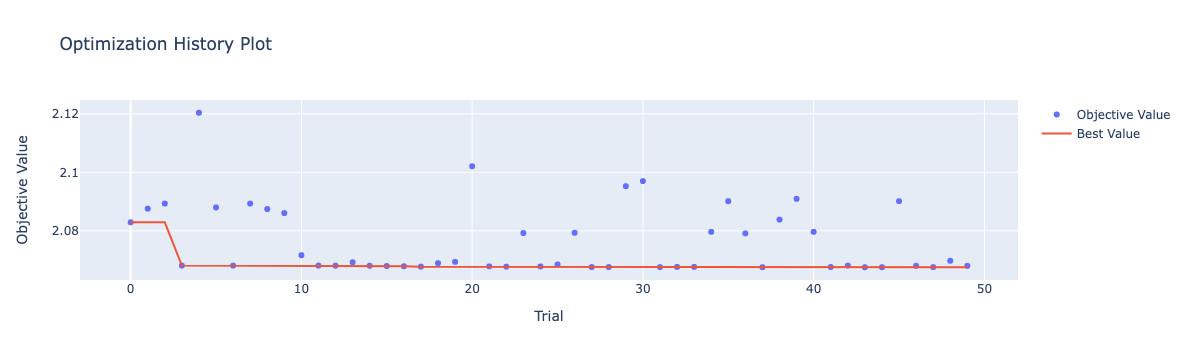

In [28]:
fig = optuna.visualization.plot_optimization_history(study)
display(fig)

(screenshot for GitHub)
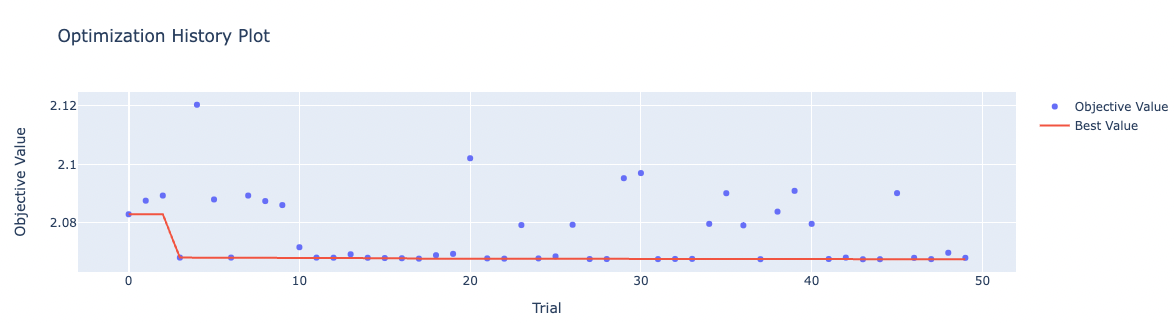

In [29]:
import joblib
joblib.dump(study, "saved_models/xgboost/xgboost_study.pkl")

['saved_models/xgboost/xgboost_study.pkl']

In [30]:
best_bst.save_model("saved_models/xgboost/xgboost.model")

In [10]:
# Reloading model
best_bst = xgb.Booster()
best_bst.load_model("saved_models/xgboost/xgboost.model")

Accuracy: 0.206
Precision (micro): 0.206
Precision (macro): 0.115
Recall (micro): 0.206
Recall (macro): 0.134
F1 (micro): 0.206
F1 (macro): 0.086
ROC-AUC: 0.5047102979702176


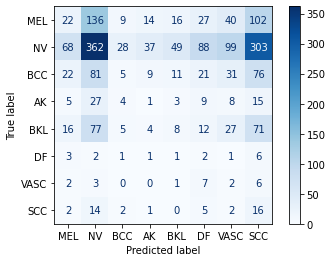

In [33]:
# Predicting the validation set results
dataset_val = xgb.DMatrix(validation_cnn_output, label=np.argmax(validation_y, axis=1))
y_pred = best_bst.predict(dataset_val)

# Evaluating

y_test = np.argmax(validation_y, axis=1)
cm = confusion_matrix(y_test, y_pred)

onehotencoder = OneHotEncoder()
y_test_onehot = onehotencoder.fit_transform([[y] for y in y_test]).toarray()
y_pred_onehot = onehotencoder.fit_transform([[y] for y in y_pred]).toarray()

print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'Precision (micro): {precision_score(y_test, y_pred, average="micro"):.3f}')
print(f'Precision (macro): {precision_score(y_test, y_pred, average="macro"):.3f}')
print(f'Recall (micro): {recall_score(y_test, y_pred, average="micro"):.3f}')
print(f'Recall (macro): {recall_score(y_test, y_pred, average="macro"):.3f}')
print(f'F1 (micro): {f1_score(y_test, y_pred, average="micro"):.3f}')
print(f'F1 (macro): {f1_score(y_test, y_pred, average="macro"):.3f}')
print(f'ROC-AUC: {roc_auc_score(y_test_onehot, y_pred_onehot, multi_class="ovo")}')

#Confusion matrix: 
labels=["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]
labels_sorted = sorted(labels)

# Rearrange
sorted_to_real_idx = {labels_sorted.index(l): labels.index(l) for l in labels_sorted}
sorted_to_real_fn = lambda y_sorted: np.array([sorted_to_real_idx[i] for i in y_sorted])
cm = confusion_matrix(
    sorted_to_real_fn(y_test),
    sorted_to_real_fn(y_pred),
)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [31]:
# Predicting the test set results
dataset_test = xgb.DMatrix(test_cnn_output, label=np.argmax(test_y, axis=1))
y_pred = best_bst.predict(dataset_test)

# Evaluating

y_test = np.argmax(test_y, axis=1)
cm = confusion_matrix(y_test, y_pred)

onehotencoder = OneHotEncoder()
y_test_onehot = onehotencoder.fit_transform([[y] for y in y_test]).toarray()
y_pred_onehot = onehotencoder.fit_transform([[y] for y in y_pred]).toarray()

# print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
# print(f'Precision (micro): {precision_score(y_test, y_pred, average="micro"):.3f}')
# print(f'Precision (macro): {precision_score(y_test, y_pred, average="macro"):.3f}')
# print(f'Recall (micro): {recall_score(y_test, y_pred, average="micro"):.3f}')
# print(f'Recall (macro): {recall_score(y_test, y_pred, average="macro"):.3f}')
# print(f'F1 (micro): {f1_score(y_test, y_pred, average="micro"):.3f}')
# print(f'F1 (macro): {f1_score(y_test, y_pred, average="macro"):.3f}')
# print(f'ROC-AUC: {roc_auc_score(y_test_onehot, y_pred_onehot, multi_class="ovo")}')

#Confusion matrix: 
labels=["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]
labels_sorted = sorted(labels)

# Rearrange
sorted_to_real_idx = {labels_sorted.index(l): labels.index(l) for l in labels_sorted}
sorted_to_real_fn = lambda y_sorted: np.array([sorted_to_real_idx[i] for i in y_sorted])
y_true = sorted_to_real_fn(y_test)
y_pred = sorted_to_real_fn(y_pred)


Classification Report
              precision    recall  f1-score   support

         MEL      0.165     0.059     0.087       895
          NV      0.500     0.333     0.400      2592
         BCC      0.209     0.034     0.058       684
          AK      0.047     0.050     0.049       160
         BKL      0.128     0.044     0.065       502
          DF      0.009     0.091     0.016        44
        VASC      0.014     0.170     0.025        47
         SCC      0.030     0.324     0.055       142

    accuracy                          0.203      5066
   macro avg      0.138     0.138     0.094      5066
weighted avg      0.328     0.203     0.238      5066

Accuracy: 0.2027
ROC AUC: 0.5063


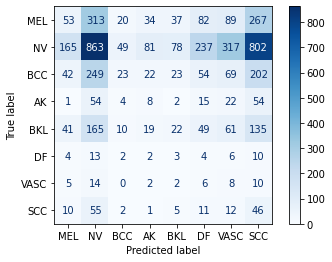

In [32]:
print ("Classification Report")
print(sklearn_metrics.classification_report(y_true, y_pred, labels=range(8), target_names=labels, digits=3))
print(f"Accuracy: {sklearn_metrics.accuracy_score(y_true, y_pred):.4f}")
#'ovr' Stands for One-vs-rest. Computes the AUC of each class against the rest
print(f"ROC AUC: {sklearn_metrics.roc_auc_score(y_test_onehot, y_pred_onehot, multi_class='ovr'):.4f}")

cm = sklearn_metrics.confusion_matrix(y_true, y_pred)
disp = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()